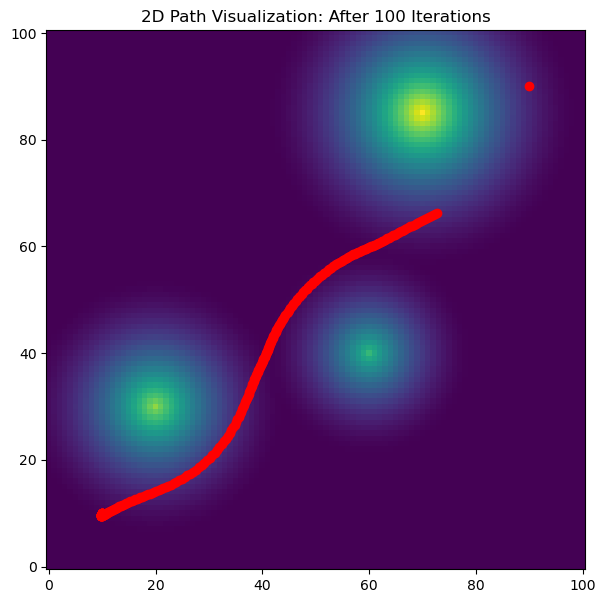

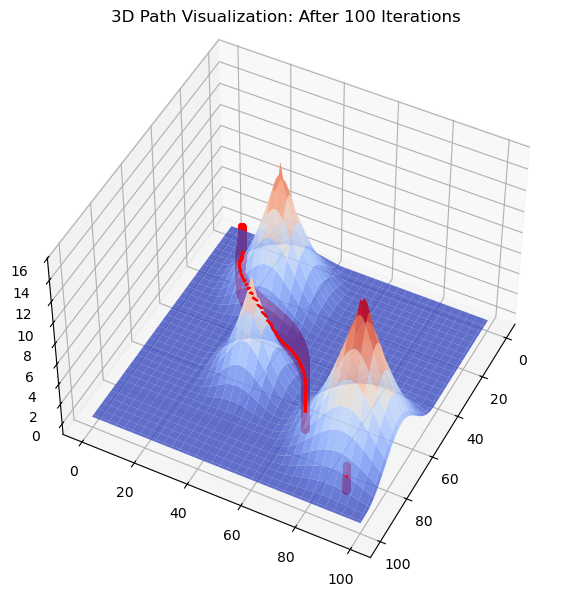

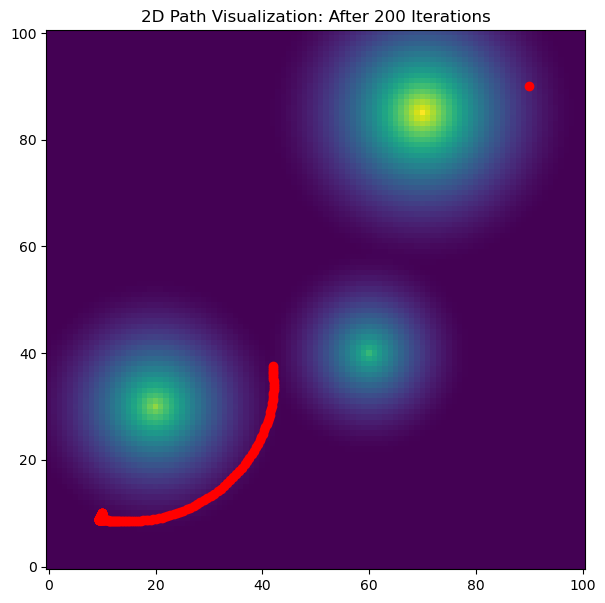

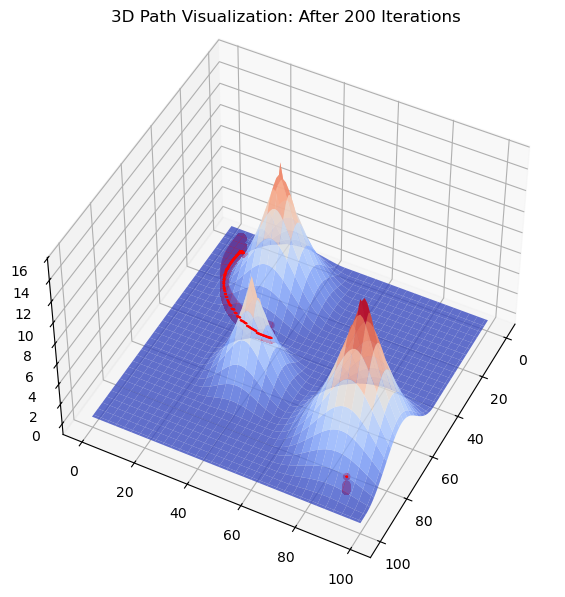

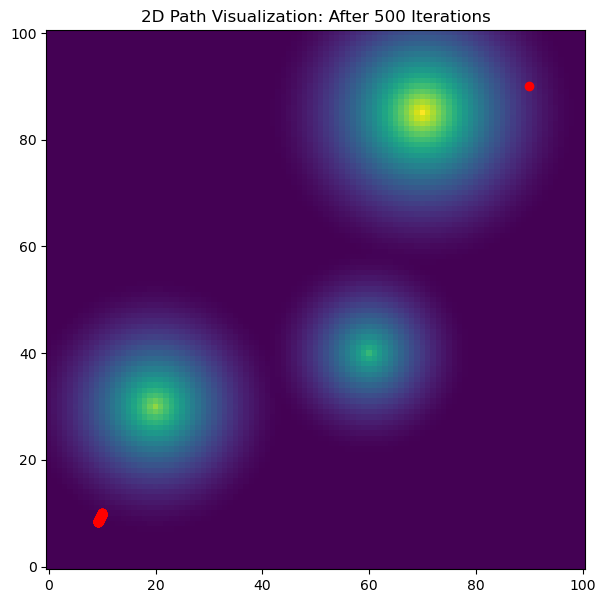

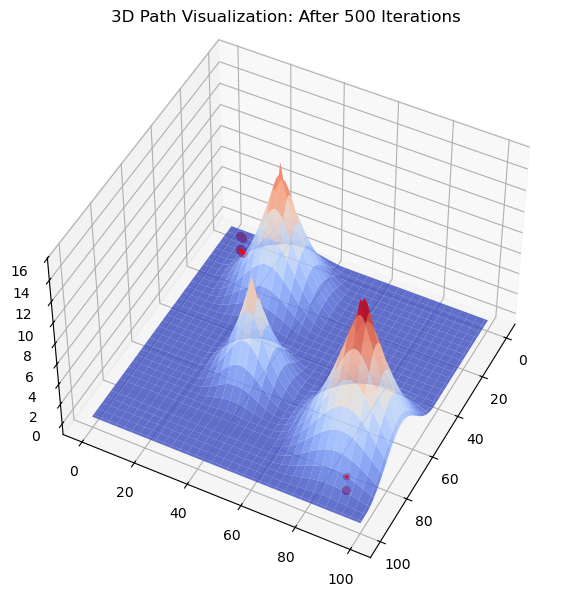

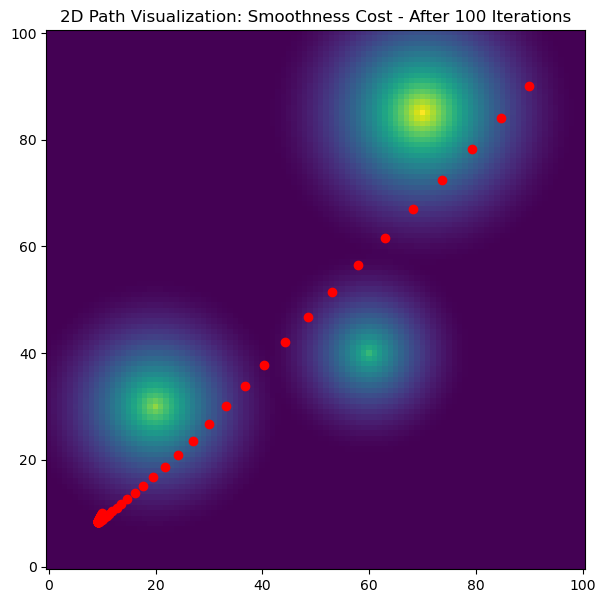

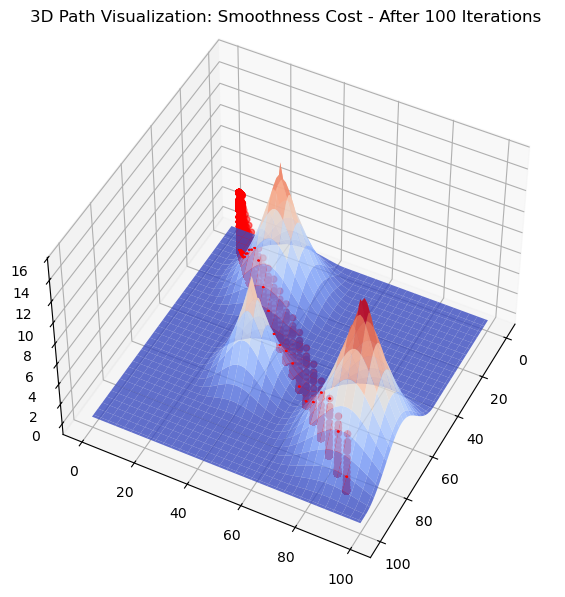

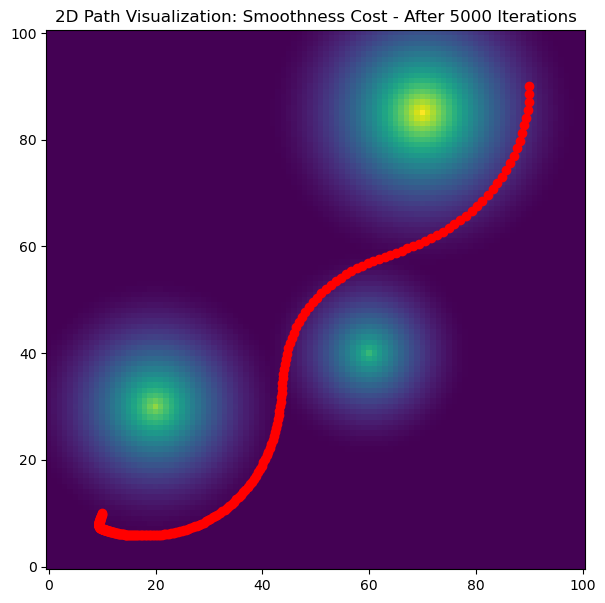

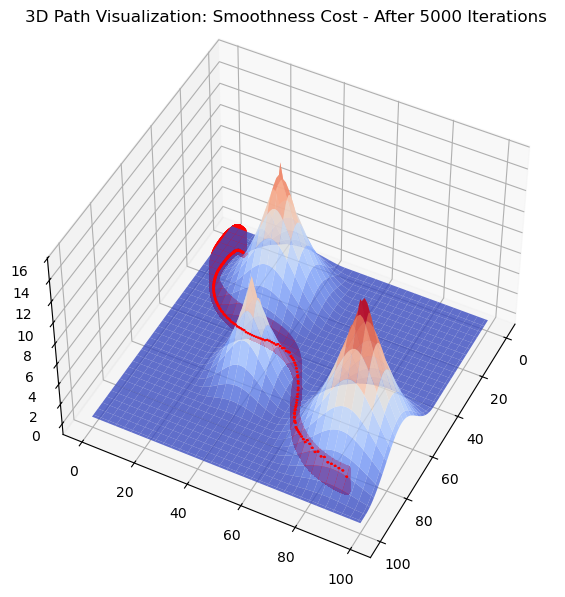

In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.patches import Ellipse

# Function to calculate the obstacle cost and its gradient
def calculate_obstacle_cost(N, OBST, epsilon):
    obs_cost = np.zeros((N, N))
    for i in range(OBST.shape[0]):
        t = np.ones((N, N))
        t[OBST[i, 0], OBST[i, 1]] = 0
        t_cost = distance_transform_edt(t)
        t_cost[t_cost > epsilon[i]] = epsilon[i]
        t_cost = 1 / (2 * epsilon[i]) * (t_cost - epsilon[i]) ** 2
        obs_cost += t_cost
    gx, gy = np.gradient(obs_cost)
    return obs_cost, gx, gy

# Function to add a 3D point for visualization
def add_point(ax, x, y, z, fc=None, ec=None, radius=0.005):
    xy_len, z_len = ax.get_figure().get_size_inches()
    axis_length = [x[1] - x[0] for x in [ax.get_xbound(), ax.get_ybound(), ax.get_zbound()]]
    axis_rotation = {
        'z': ((x, y, z), axis_length[1] / axis_length[0]),
        'y': ((x, z, y), axis_length[2] / axis_length[0] * xy_len / z_len),
        'x': ((y, z, x), axis_length[2] / axis_length[1] * xy_len / z_len)
    }
    for a, ((x0, y0, z0), ratio) in axis_rotation.items():
        p = Ellipse((x0, y0), width=radius, height=radius * ratio, fc=fc, ec=ec)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=z0, zdir=a)

# Function to plot the path in both 2D and 3D
def plot_path(path, obs_cost, N, title, figsize=(7, 7)):
    tt = path.shape[0]
    path_values = np.zeros((tt, 1))
    for i in range(tt):
        path_values[i] = obs_cost[int(np.floor(path[i, 0])), int(np.floor(path[i, 1]))]

    # Plot 2D
    plt.figure(figsize=figsize)
    plt.imshow(obs_cost.T, origin='lower')
    plt.plot(path[:, 0], path[:, 1], 'ro')
    plt.title(f"2D Path Visualization: {title}")

    # Plot 3D
    fig3d = plt.figure(figsize=figsize)
    ax3d = fig3d.add_subplot(111, projection='3d')
    xx, yy = np.meshgrid(range(N), range(N))
    ax3d.plot_surface(xx, yy, obs_cost.T, cmap=plt.get_cmap('coolwarm'), alpha=0.8)
    ax3d.scatter(path[:, 0], path[:, 1], path_values, s=20, c='r')
    for i, (x, y) in enumerate(path):
        z = path_values[i][0]
        add_point(ax3d, x, y, z, fc="r", radius=1)
    ax3d.view_init(elev=47, azim=27)
    plt.title(f"3D Path Visualization: {title}")
    plt.show()

# Parameters
waypoints = 300
N = 101
OBST = np.array([[20, 30], [60, 40], [70, 85]])
epsilon = np.array([25, 20, 30])

# Calculate obstacle cost and gradients
obs_cost, gx, gy = calculate_obstacle_cost(N, OBST, epsilon)

# Start and goal positions
SX, SY = 10, 10
GX, GY = 90, 90

# Initialize trajectory as a straight line
traj = np.zeros((waypoints, 2))
traj[0] = [SX, SY]
traj[-1] = [GX, GY]
for i in range(1, waypoints - 1):
    traj[i, 0] = SX + i * (GX - SX) / (waypoints - 1)
    traj[i, 1] = SY + i * (GY - SY) / (waypoints - 1)

# Gradient Descent Optimization
def gradient_descent(path, gx, gy, num_iter, obstacle_weight=0.8, smooth_weight=4.0, step_size=0.1):
    for iteration in range(num_iter):
        old_path = np.copy(path)
        for k in range(1, path.shape[0] - 1):  # Keep start and end points fixed
            x, y = int(np.floor(path[k, 0])), int(np.floor(path[k, 1]))
            grad_x = obstacle_weight * gx[x, y] + smooth_weight * (path[k, 0] - path[k - 1, 0])
            grad_y = obstacle_weight * gy[x, y] + smooth_weight * (path[k, 1] - path[k - 1, 1])
            path[k, 0] -= step_size * grad_x
            path[k, 1] -= step_size * grad_y
        if np.linalg.norm(path - old_path) < 1e-3:
            break
    return path

# Run gradient descent and plot
path = gradient_descent(traj, gx, gy, 100)
plot_path(path, obs_cost, N, "After 100 Iterations")

path = gradient_descent(traj, gx, gy, 200)
plot_path(path, obs_cost, N, "After 200 Iterations")

path = gradient_descent(traj, gx, gy, 500)
plot_path(path, obs_cost, N, "After 500 Iterations")

# Smoothness Cost Augmentation
def smoothness_cost(path, gx, gy, num_iter, obstacle_weight=0.8, smooth_weight=4.0, step_size=0.1):
    for iteration in range(num_iter):
        old_path = np.copy(path)
        for k in range(1, path.shape[0] - 1):
            x, y = int(np.floor(path[k, 0])), int(np.floor(path[k, 1]))
            smooth_x = -path[k - 1, 0] + 2 * path[k, 0] - path[k + 1, 0]
            smooth_y = -path[k - 1, 1] + 2 * path[k, 1] - path[k + 1, 1]
            grad_x = obstacle_weight * gx[x, y] + smooth_weight * smooth_x
            grad_y = obstacle_weight * gy[x, y] + smooth_weight * smooth_y
            path[k, 0] -= step_size * grad_x
            path[k, 1] -= step_size * grad_y
        if np.linalg.norm(path - old_path) < 1e-3:
            break
    return path

# Run smoothness-augmented gradient descent and plot
path = smoothness_cost(traj, gx, gy, 100)
plot_path(path, obs_cost, N, "Smoothness Cost - After 100 Iterations")

path = smoothness_cost(traj, gx, gy, 5000)
plot_path(path, obs_cost, N, "Smoothness Cost - After 5000 Iterations")